# Model Training

In [1]:
import tensorflow as tf
from transformers import BertTokenizerFast, TFBertForTokenClassification, DataCollatorForTokenClassification
from datasets import load_dataset
import numpy as np
from sklearn.metrics import classification_report
import torch

2025-05-28 19:04:21.146985: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-28 19:04:27.677028: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-28 19:04:27.688634: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-28 19:04:28.813862: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-28 19:04:31.059388: I tensorflow/core/platform/cpu_feature_guar

In [2]:
# Checking GPU availability
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


2025-05-28 19:06:00.648490: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-05-28 19:06:00.781837: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-05-28 19:06:00.781882: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [3]:
# Loading the dataset
dataset = load_dataset("conll2003", cache_dir="./cache")

In [4]:
# Splitting the dataset
train_dataset = dataset['train']
validation_dataset = dataset['validation']
test_dataset = dataset['test']

In [5]:
# Loading tokenizer, model and data collator
model_name = "bert-base-cased"
tokenizer = BertTokenizerFast.from_pretrained(model_name, cache_dir="./cache")
model = TFBertForTokenClassification.from_pretrained(model_name, num_labels=9) # Check EDA.ipynb for number of labels
data_collator = DataCollatorForTokenClassification(tokenizer)

2025-05-28 19:06:21.151287: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-05-28 19:06:21.151382: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-05-28 19:06:21.151398: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-05-28 19:06:21.421317: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-05-28 19:06:21.421376: I external/local_xla/xla/stream_executor

In [6]:
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(
        examples["tokens"],
        truncation=True,
        is_split_into_words=True,
        padding=True,
        return_tensors="tf"
    )
    
    labels = []
    for i, label in enumerate(examples["ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        aligned_labels = []
        previous_word_idx = None
        for word_idx in word_ids:
            if word_idx is None:  # Special tokens ([CLS], [SEP])
                aligned_labels.append(-100)
            elif word_idx != previous_word_idx:  # First token of a word
                aligned_labels.append(label[word_idx])
            else:  # Subword token
                aligned_labels.append(-100)
            previous_word_idx = word_idx
        labels.append(aligned_labels)
    
    tokenized_inputs["labels"] = tf.constant(labels)
    return tokenized_inputs

# Apply tokenization
train_dataset = dataset["train"].map(tokenize_and_align_labels, batched=True)
val_dataset = dataset["validation"].map(tokenize_and_align_labels, batched=True)
test_dataset = dataset["test"].map(tokenize_and_align_labels, batched=True)

Map: 100%|██████████| 3453/3453 [00:00<00:00, 8066.97 examples/s]


In [7]:
def convert_to_tf_dataset(hf_dataset, batch_size=8):
    return hf_dataset.to_tf_dataset(
        columns=["input_ids", "token_type_ids", "attention_mask"],
        label_cols=["labels"],
        shuffle=True,
        batch_size=batch_size,
        collate_fn=data_collator
    )

# Convert datasets
tf_train_dataset = convert_to_tf_dataset(train_dataset)
tf_val_dataset = convert_to_tf_dataset(val_dataset)
tf_test_dataset = convert_to_tf_dataset(test_dataset)


/mnt/d/github/Named_Entity_Recognition/ner_venv/lib/python3.11/site-packages/datasets/arrow_dataset.py:400: FutureWarning: The output of `to_tf_dataset` will change when a passing single element list for `labels` or `columns` in the next datasets version. To return a tuple structure rather than dict, pass a single string.
Old behaviour: columns=['a'], labels=['labels'] -> (tf.Tensor, tf.Tensor)  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor)  
New behaviour: columns=['a'],labels=['labels'] -> ({'a': tf.Tensor}, {'labels': tf.Tensor})  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor) 
  warnings.warn(
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [8]:
# Model Training
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, ignore_class=-100),
    metrics=["accuracy"]
)

history = model.fit(
    tf_train_dataset,
    validation_data=tf_val_dataset,
    epochs=3,
    verbose=1,
)

Epoch 1/3


2025-05-28 19:06:57.434245: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f0490cf5290 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-05-28 19:06:57.434292: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2025-05-28 19:06:57.543048: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-05-28 19:06:57.649456: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
I0000 00:00:1748439417.748961    8931 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1756/1756 [==============================] - 320s 167ms/step - loss: 0.1010 - accuracy: 0.1127 - val_loss: 0.0462 - val_accuracy: 0.1049
Epoch 2/3
1756/1756 [==============================] - 293s 167ms/step - loss: 0.0265 - accuracy: 0.1144 - val_loss: 0.0414 - val_accuracy: 0.1050
Epoch 3/3
1756/1756 [==============================] - 288s 164ms/step - loss: 0.0169 - accuracy: 0.1157 - val_loss: 0.0409 - val_accuracy: 0.1056


In [9]:
label_list = dataset["train"].features["ner_tags"].feature.names

In [11]:
from sklearn.metrics import classification_report
import numpy as np

def evaluate_model(model, tf_dataset, label_list):
    predictions, true_labels = [], []
    for batch in tf_dataset:
        logits = model(batch[0])[0].numpy()  # Model outputs logits
        labels = batch[1].numpy()  # Access labels directly from batch[1]
        
        for i in range(logits.shape[0]):
            pred = np.argmax(logits[i], axis=-1)
            true = labels[i]
            valid_indices = true != -100  # Filter out ignored tokens
            predictions.extend([label_list[p] for p in pred[valid_indices]])
            true_labels.extend([label_list[t] for t in true[valid_indices]])
    
    return classification_report(true_labels, predictions, labels=label_list[1:])  # Exclude "O"

# Evaluate on test set
print(evaluate_model(model, tf_test_dataset, label_list))

              precision    recall  f1-score   support

       B-PER       0.97      0.95      0.96      1617
       I-PER       0.98      0.99      0.99      1156
       B-ORG       0.88      0.92      0.90      1661
       I-ORG       0.85      0.92      0.89       835
       B-LOC       0.91      0.94      0.92      1668
       I-LOC       0.83      0.90      0.86       257
      B-MISC       0.83      0.83      0.83       702
      I-MISC       0.63      0.71      0.67       216

   micro avg       0.90      0.93      0.91      8112
   macro avg       0.86      0.89      0.88      8112
weighted avg       0.90      0.93      0.91      8112



In [ ]:
# Save the model
model.save_pretrained("./bert_ner_model")
# Save the tokenizer
tokenizer.save_pretrained("./bert_ner_tokenizer")
# Save the label list
import json
with open("./label_list.json", "w") as f:
    json.dump(label_list, f)
# Save the training history
import pandas as pd
history_df = pd.DataFrame(history.history)
history_df.to_csv("./training_history.csv", index=False)


In [14]:
# testing the model
def predict_ner(text):
    inputs = tokenizer(text, return_tensors="tf", truncation=True, padding=True, is_split_into_words=False)
    outputs = model(inputs)
    logits = outputs[0].numpy()
    predictions = np.argmax(logits, axis=-1)[0]
    
    tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])
    predicted_labels = [label_list[p] for p in predictions]
    
    return list(zip(tokens, predicted_labels))
# Example usage
text = "Stephen was a theoretical physicist and cosmologist."
predictions = predict_ner(text.split())
for token, label in predictions:
    print(f"{token}: {label}")
# Example usage
text = "Barack Obama was the 44th President of the United States."
predictions = predict_ner(text.split())
for token, label in predictions:
    print(f"{token}: {label}")

[CLS]: O
Stephen: B-PER
[SEP]: O
[PAD]: B-PER
[PAD]: B-PER
[PAD]: O
[CLS]: O
Barack: B-PER
[SEP]: O
[PAD]: B-PER


In [17]:
# Label mapping
labels = dataset['train'].features['ner_tags'].feature.names
label_map = {i: label for i, label in enumerate(labels)}
num_labels = len(label_map)
print("Label mapping:", label_map)

Label mapping: {0: 'O', 1: 'B-PER', 2: 'I-PER', 3: 'B-ORG', 4: 'I-ORG', 5: 'B-LOC', 6: 'I-LOC', 7: 'B-MISC', 8: 'I-MISC'}


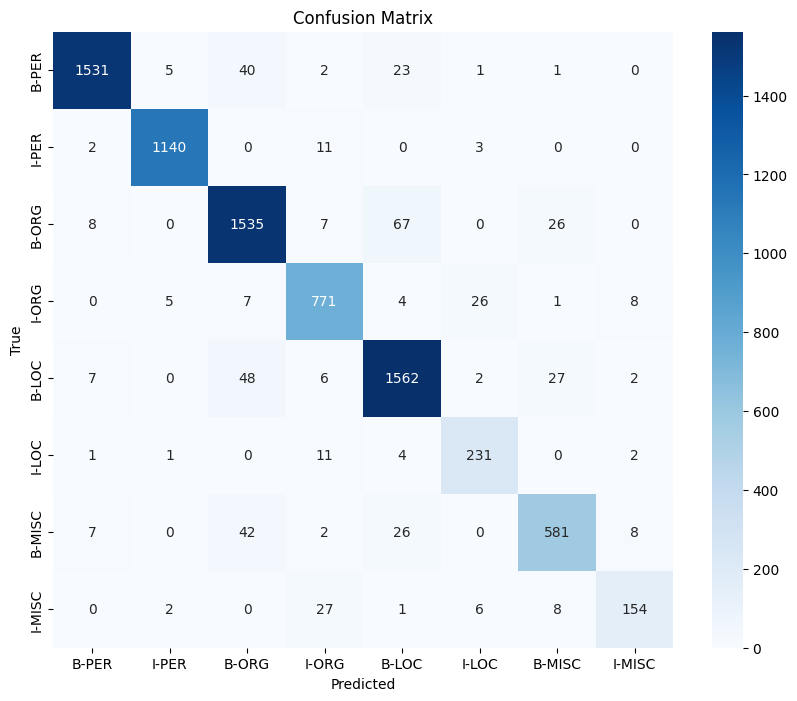

In [18]:
# confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(true_labels, predictions, label_list):
    cm = confusion_matrix(true_labels, predictions, labels=label_list[1:])  # Exclude "O"
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_list[1:], yticklabels=label_list[1:])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.savefig("plots/confusion_matrix.png")
    plt.show()
# Get predictions and true labels for confusion matrix
predictions, true_labels = [], []
for batch in tf_test_dataset:
    logits = model(batch[0])[0].numpy()  # Model outputs logits
    labels = batch[1].numpy()  # Access labels directly from batch[1]
    
    for i in range(logits.shape[0]):
        pred = np.argmax(logits[i], axis=-1)
        true = labels[i]
        valid_indices = true != -100  # Filter out ignored tokens
        predictions.extend([label_list[p] for p in pred[valid_indices]])
        true_labels.extend([label_list[t] for t in true[valid_indices]])
plot_confusion_matrix(true_labels, predictions, label_list)

